<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge_2_R20.97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [414]:
#!pip install yfinance --upgrade --no-cache-dir
#!pip install xgboost


In [415]:
# Análise de dados e manipulação
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots



from statsmodels.tsa.stattools import adfuller

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor


# pegar os dados
import yfinance as yf
# Manipulação de datas
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import matplotlib.dates as mdates
#extras
import warnings
import logging
from tqdm import tqdm
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Verificação de versões (opcional)
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.6.1


In [416]:
# Configuração de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignorar warnings desnecessários
warnings.filterwarnings('ignore')

print("Baixando dados...")

# Baixar os dados do Ibovespa
df = yf.download('^BVSP', start='1994-07-01', end=datetime.now().strftime('%Y-%m-%d'))

# Verificar se os dados foram baixados corretamente
if df.empty:
    logging.warning("Falha ao baixar os dados do Ibovespa. Verifique a conexão ou a disponibilidade do Yahoo Finance.")
else:
    logging.info(f"Dados baixados com sucesso! Total de registros: {df.shape[0]}")

# Preencher valores ausentes e garantir que o índice seja datetime
df = df.ffill()
df.index = pd.to_datetime(df.index)


[*********************100%***********************]  1 of 1 completed

Baixando dados...


In [417]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [418]:
print(df.columns)
print(df.index)
print(df.describe)

MultiIndex([( 'Close', '^BVSP'),
            (  'High', '^BVSP'),
            (   'Low', '^BVSP'),
            (  'Open', '^BVSP'),
            ('Volume', '^BVSP')],
           names=['Price', 'Ticker'])
DatetimeIndex(['1994-07-04', '1994-07-05', '1994-07-06', '1994-07-07',
               '1994-07-08', '1994-07-11', '1994-07-12', '1994-07-13',
               '1994-07-14', '1994-07-15',
               ...
               '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-24',
               '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28',
               '2025-03-05', '2025-03-06'],
              dtype='datetime64[ns]', name='Date', length=7595, freq=None)
<bound method NDFrame.describe of Price               Close           High            Low           Open  \
Ticker              ^BVSP          ^BVSP          ^BVSP          ^BVSP   
Date                                                                     
1994-07-04    3580.899902    3712.100098    3579.699951    3623.199951   
1

In [419]:
# 🔹 Verificar o intervalo de datas do DataFrame
print("Data mínima:", df.index.min())
print("Data máxima:", df.index.max())

# 🔹 Selecionar os últimos 20 anos de dados
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=20)
df = df.loc[start_date:end_date]

# 🔹 Remover finais de semana (quando a bolsa está fechada)
df = df[df.index.dayofweek < 5]  # 0-4 representa dias úteis (segunda a sexta)

print("Data mínima após filtro:", df.index.min())
print("Data máxima após filtro:", df.index.max())

Data mínima: 1994-07-04 00:00:00
Data máxima: 2025-03-06 00:00:00
Data mínima após filtro: 2005-03-07 00:00:00
Data máxima após filtro: 2025-03-06 00:00:00


In [420]:
# 🔹 Criar Features relevantes para a precisão do modelo
df['Return'] = df[('Close', '^BVSP')].pct_change()  # Retornos diários
df['MA_10'] = df[('Close', '^BVSP')].rolling(window=10).mean()  # Média móvel de 10 dias
df['MA_50'] = df[('Close', '^BVSP')].rolling(window=50).mean()  # Média móvel de 50 dias
df['Volatility'] = df['Return'].rolling(window=10).std()  # Volatilidade de 10 dias
# Adicionar mais features
df['EMA_10'] = df[('Close', '^BVSP')].ewm(span=10, adjust=False).mean()  # Média móvel exponencial
df['EMA_50'] = df[('Close', '^BVSP')].ewm(span=50, adjust=False).mean()
df['RSI'] = 100 - (100 / (1 + df['Return'].rolling(window=14).mean()))  # RSI (Relative Strength Index)

# 🔹 Remover valores NaN gerados pelas operações de rolling
df = df.dropna()


print("DataFrame com Features Criadas:")
print(df.head())


DataFrame com Features Criadas:
Price         Close     High      Low     Open Volume    Return    MA_10  \
Ticker        ^BVSP    ^BVSP    ^BVSP    ^BVSP  ^BVSP                      
Date                                                                       
2005-05-17  24413.0  24513.0  24024.0  24362.0      0  0.001395  24822.2   
2005-05-18  24898.0  24967.0  24410.0  24410.0      0  0.019866  24764.6   
2005-05-19  24829.0  24882.0  24530.0  24882.0      0 -0.002771  24703.9   
2005-05-20  24522.0  24836.0  24494.0  24827.0      0 -0.012365  24597.2   
2005-05-23  24215.0  24586.0  24208.0  24525.0      0 -0.012519  24472.2   

Price          MA_50 Volatility        EMA_10        EMA_50       RSI  
Ticker                                                                 
Date                                                                   
2005-05-17  26057.62   0.017731  24614.826751  25973.261607 -0.224119  
2005-05-18  25966.48   0.015806  24666.312796  25931.094485  0.145020  

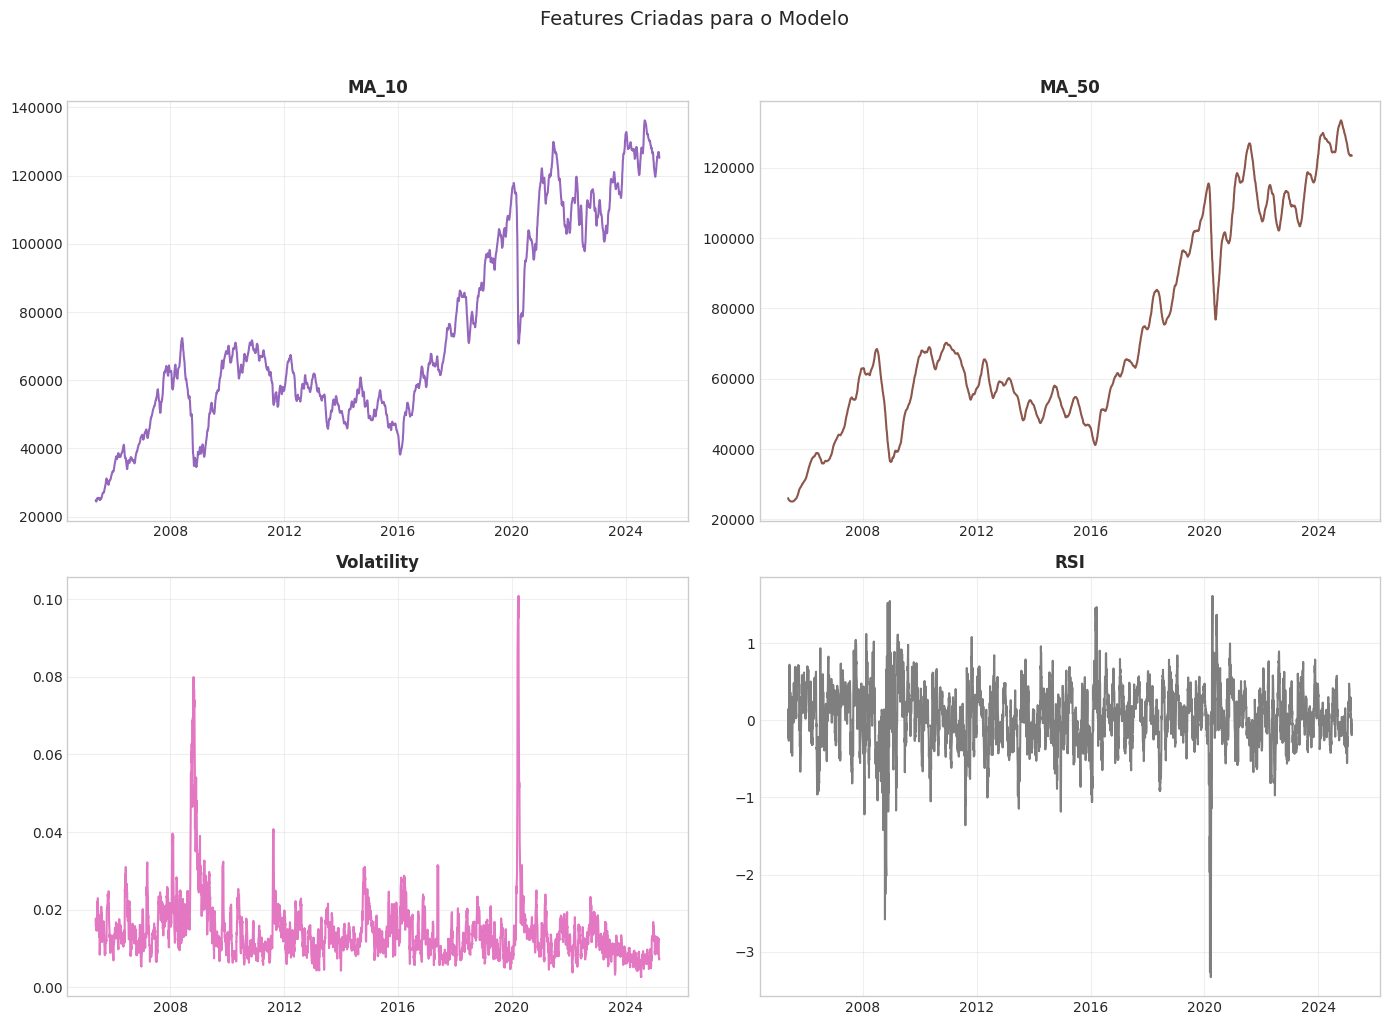

In [421]:
# Plot das features
features = ['MA_10', 'MA_50', 'Volatility', 'RSI']
colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.plot(df[feature], color=colors[i], linewidth=1.5)
    plt.title(feature, fontweight='bold')
    plt.grid(alpha=0.3)

plt.suptitle('Features Criadas para o Modelo', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [422]:
# 🔹 Definir cutoff_date dentro do intervalo de datas do DataFrame
cutoff_date = df.index[int(0.99 * len(df))]  # 80% dos dados para treino
print("Cutoff date:", cutoff_date)

# 🔹 Separação treino/teste baseada no tempo
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

# 🔹 Verificar o tamanho dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", len(train))
print("Tamanho do conjunto de teste:", len(test))

if len(train) == 0:
    raise ValueError("O conjunto de treino está vazio. Verifique o cutoff_date.")

Cutoff date: 2024-12-19 00:00:00
Tamanho do conjunto de treino: 4854
Tamanho do conjunto de teste: 50


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

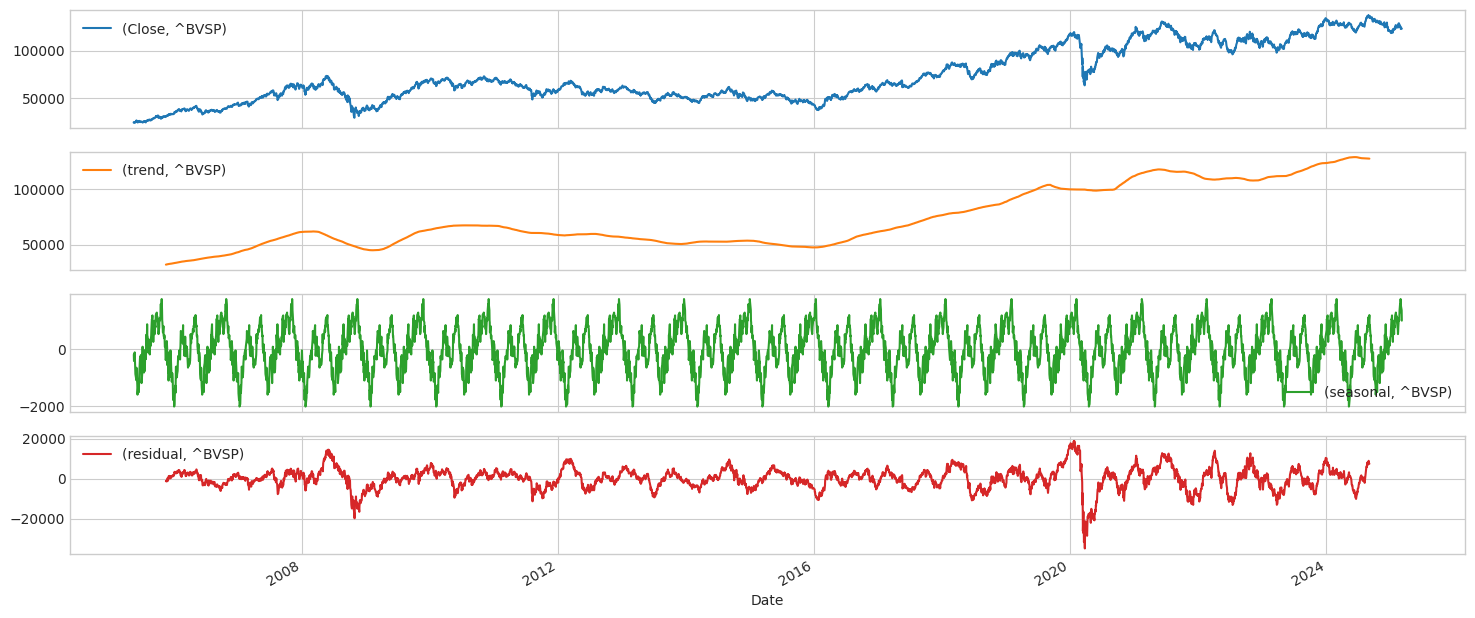

In [423]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Selecionando a série correta
serie_temporal = df[('Close', '^BVSP')].dropna()

# Decomposição sazonal
stl = seasonal_decompose(serie_temporal, period=252)  # 252 dias úteis = ~1 ano

# Adicionando os componentes ao DataFrame
df[('trend', '^BVSP')] = stl.trend.shift(1)
df[('seasonal', '^BVSP')] = stl.seasonal.shift(1)
df[('residual', '^BVSP')] = stl.resid.shift(1)

# Plotando os componentes
df[[('Close', '^BVSP'), ('trend', '^BVSP'), ('seasonal', '^BVSP'), ('residual', '^BVSP')]].plot(subplots=True, figsize=(18, 8))


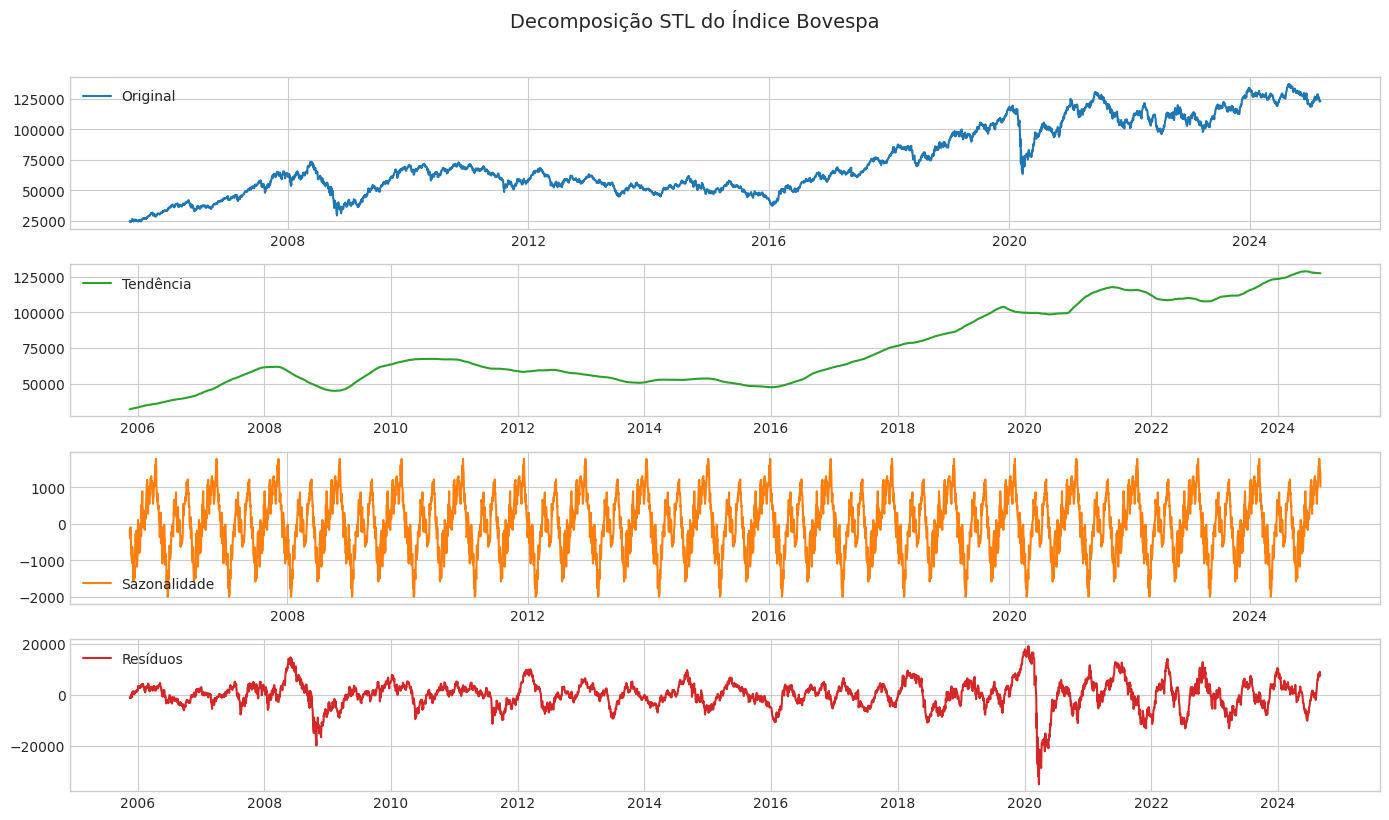

In [424]:
# Plot da decomposição STL
plt.figure(figsize=(14, 8))
plt.subplot(4, 1, 1)
plt.plot(df[('Close', '^BVSP')], label='Original', color='#1f77b4')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df[('trend', '^BVSP')], label='Tendência', color='#2ca02c')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df[('seasonal', '^BVSP')], label='Sazonalidade', color='#ff7f0e')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df[('residual', '^BVSP')], label='Resíduos', color='#d62728')
plt.legend()

plt.suptitle('Decomposição STL do Índice Bovespa', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [425]:
# 🔹 Definir X e y
X = df.drop(columns=[('Close', '^BVSP')])  # Ajustado para multi-index
y = df[('Close', '^BVSP')]  # Ajustado para multi-index
X_train, X_test = X.loc[train.index], X.loc[test.index]
y_train, y_test = y.loc[train.index], y.loc[test.index]

# 🔹 Verificar o tamanho de X_train e y_train
print("Tamanho de X_train:", X_train.shape)
print("Tamanho de y_train:", y_train.shape)

if X_train.shape[0] == 0:
    raise ValueError("X_train está vazio. Verifique as colunas e o cutoff_date.")

Tamanho de X_train: (4854, 14)
Tamanho de y_train: (4854,)


In [426]:
# 🔹 Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [427]:
# 🔹 Treinar modelo (Exemplo com RandomForest)
model = RandomForestRegressor(n_estimators=90, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=90, random_state=42)

In [428]:
# 🔹 Criar datas futuras (próximos 5 dias úteis)
future_dates = [df.index[-1] + BDay(i) for i in range(1, 6)]

# 🔹 Pegar features usadas no treinamento
selected_features = X_train.columns.tolist()

# 🔹 Criar dataframe para previsão futura
future_features = pd.DataFrame(np.tile(df[selected_features].iloc[-1].values, (5, 1)),
                               columns=selected_features, index=future_dates)

# 🔹 Aplicar normalização aos dados futuros
future_features_scaled = scaler.transform(future_features)

# 🔹 Fazer previsão
future_predictions = model.predict(future_features_scaled)

# 🔹 Ajustar previsões com pequena variação aleatória
future_predictions_adjusted = [
    pred * (1 + np.random.normal(scale=0.05)) for pred in future_predictions
]

# 🔹 Exibir previsões corrigidas
print("Previsões corrigidas para os próximos 5 dias:")
for i, pred in enumerate(future_predictions_adjusted, 1):
    print(f'Dia {i}: {pred:.2f}')

Previsões corrigidas para os próximos 5 dias:
Dia 1: 126779.99
Dia 2: 122852.40
Dia 3: 127713.82
Dia 4: 133128.14
Dia 5: 122259.29


In [429]:
print("Data mínima:", df.index.min())
print("Data máxima:", df.index.max())
print("Cutoff date:", cutoff_date)
print("Tamanho do conjunto de treino:", len(train))
print("Tamanho do conjunto de teste:", len(test))
print("Tamanho de X_train:", X_train.shape)
print("Tamanho de y_train:", y_train.shape)

Data mínima: 2005-05-17 00:00:00
Data máxima: 2025-03-06 00:00:00
Cutoff date: 2024-12-19 00:00:00
Tamanho do conjunto de treino: 4854
Tamanho do conjunto de teste: 50
Tamanho de X_train: (4854, 14)
Tamanho de y_train: (4854,)


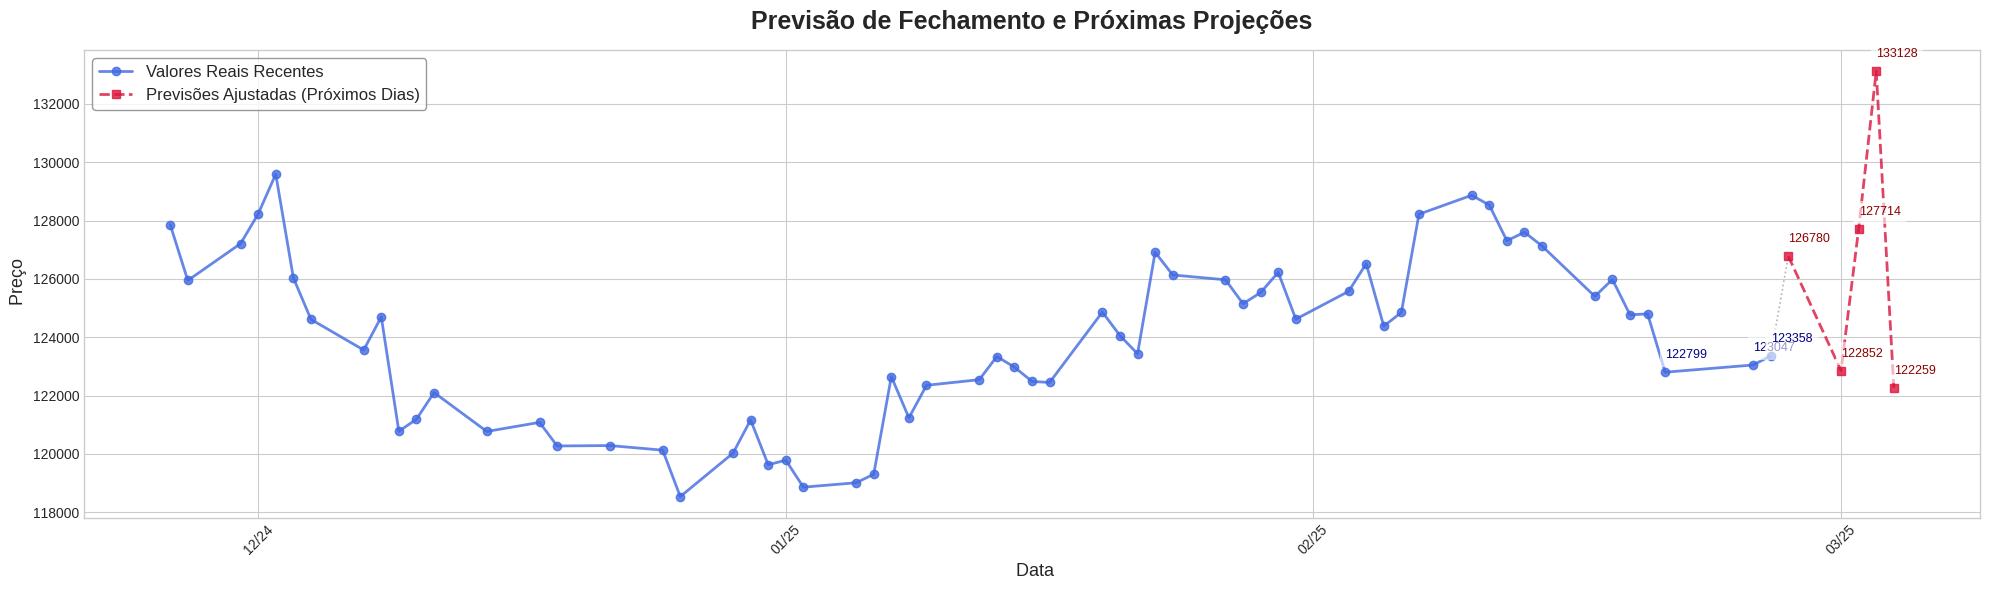

In [430]:
# 🔹 Configurando o estilo do gráfico
plt.style.use('seaborn-v0_8-whitegrid')

# 🔹 Criando o gráfico
fig, ax1 = plt.subplots(figsize=(20, 6))

# 🔹 Último valor real (corrigido para MultiIndex)
last_close = df[('Close', '^BVSP')].iloc[-1]

# 🔹 Converter previsões para floats
future_predictions_adjusted = [float(pred) for pred in future_predictions_adjusted]

# 🔹 Linha azul dos valores reais
ax1.plot(df.index[-60:], df[('Close', '^BVSP')][-60:],  # <--- Corrigido aqui!
         label='Valores Reais Recentes',
         color='royalblue', marker='o', linewidth=2, alpha=0.8)

# 🔹 Ligação entre último valor real e primeiro previsto
ax1.plot([df.index[-1], future_features.index[0]],
         [last_close, future_predictions_adjusted[0]],
         color='gray', linestyle='dotted', linewidth=1.2, alpha=0.6)

# 🔹 Linha vermelha das previsões ajustadas
ax1.plot(future_features.index, future_predictions_adjusted,
         label='Previsões Ajustadas (Próximos Dias)',
         color='crimson', linestyle='--', marker='s', linewidth=2, alpha=0.8)

# 🔹 Anotação dos valores (ajustado para MultiIndex)
for date, value in zip(df.index[-3:], df[('Close', '^BVSP')][-3:]):
    ax1.annotate(f'{value:.0f}', xy=(date, value), xytext=(0, 10),
                 textcoords='offset points', fontsize=9, color='navy',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

for date, prediction in zip(future_features.index, future_predictions_adjusted):
    ax1.annotate(f'{prediction:.0f}', xy=(date, prediction), xytext=(0, 10),
                 textcoords='offset points', fontsize=9, color='darkred',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# 🔹 Melhorando o formato do eixo X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax1.tick_params(axis='x', rotation=45)

# 🔹 Melhorando a legenda
ax1.legend(fontsize=12, loc='best', frameon=True, edgecolor='gray')

# 🔹 Melhorando título e rótulos
ax1.set_title('Previsão de Fechamento e Próximas Projeções', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel(' Data', fontsize=13)
ax1.set_ylabel(' Preço', fontsize=13)

# 🔹 Ajustando o layout para evitar cortes
plt.tight_layout()

# 🔹 Exibindo o gráfico
plt.show()

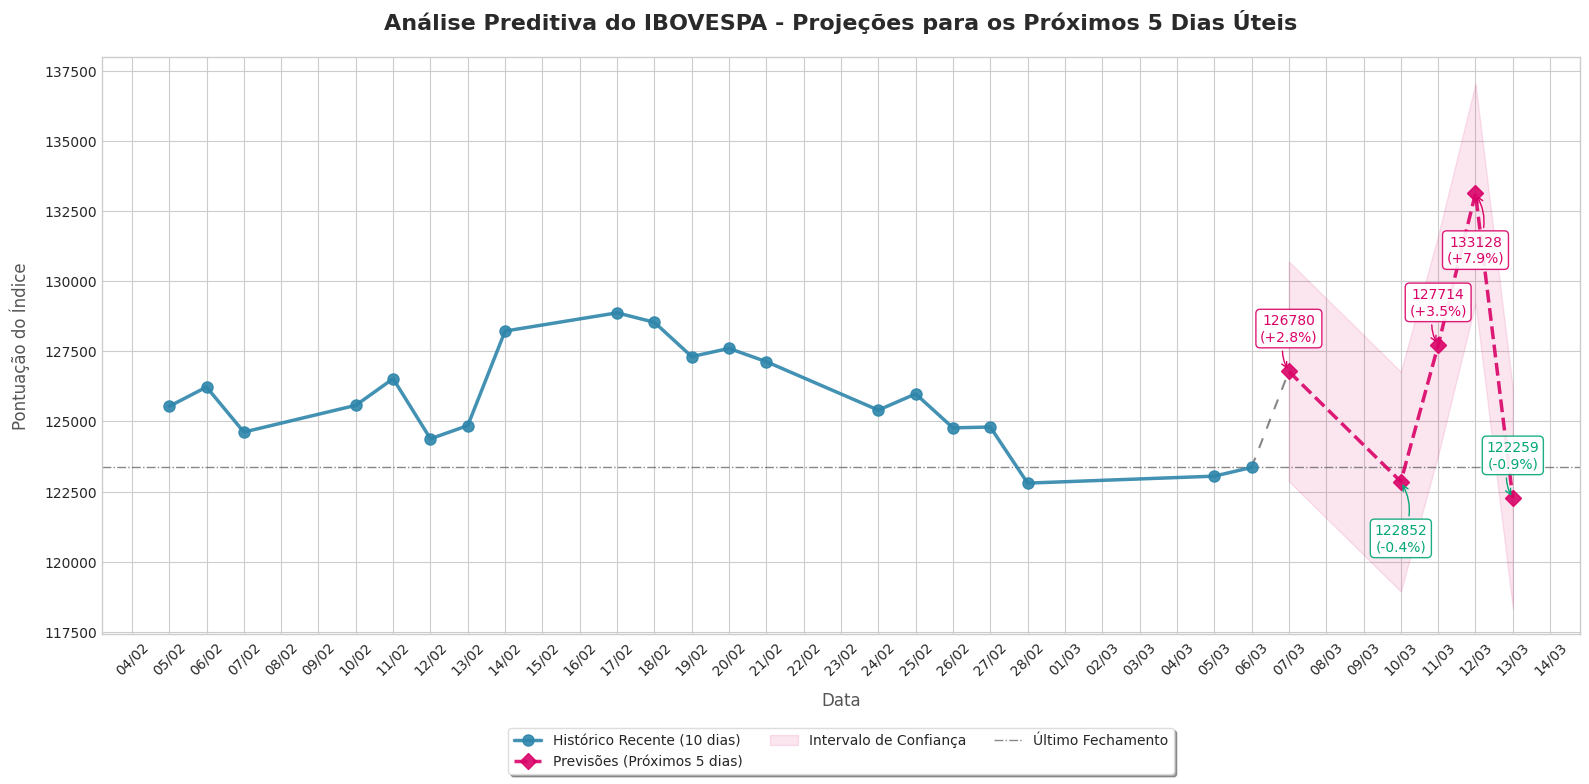

In [440]:
# 🔹 Configurações Iniciais
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fonte mais clean
colors = ['#2E86AB', '#D90368', '#04A777']  # Paleta profissional

# 🔹 Criar figura e eixo
fig, ax1 = plt.subplots(figsize=(16, 8), dpi=100)

# 🔹 Plot dos Valores Reais (Estilo Aprimorado)
real_line = ax1.plot(
    df.index[-20:],
    df[('Close', '^BVSP')][-20:],
    label='Histórico Recente (10 dias)',
    color=colors[0],
    marker='o',
    markersize=8,
    linewidth=2.5,
    alpha=0.9,
    zorder=3  # Garante que fique na frente
)

# 🔹 Linha de Transição (Estilo Atualizado)
ax1.plot(
    [df.index[-1], future_features.index[0]],
    [last_close, future_predictions_adjusted[0]],
    color='#555555',
    linestyle=(0, (5, 5)),  # Tracejado mais espaçado
    linewidth=1.5,
    alpha=0.7,
    solid_capstyle='round'
)

# 🔹 Plot das Previsões (Design Moderno)
pred_line = ax1.plot(
    future_features.index,
    future_predictions_adjusted,
    label='Previsões (Próximos 5 dias)',
    color=colors[1],
    linestyle='--',
    marker='D',
    markersize=8,
    linewidth=2.5,
    alpha=0.9,
    zorder=3
)

# 🔹 Anotações com Variação Percentual Dinâmica
for idx, (date, pred) in enumerate(zip(future_features.index, future_predictions_adjusted)):
    variation = ((pred / last_close) - 1) * 100
    color = colors[1] if variation >= 0 else colors[2]

    ax1.annotate(
        f'{pred:.0f}\n({variation:+.1f}%)',
        xy=(date, pred),
        xytext=(0, 20 if idx%2==0 else -30),
        textcoords='offset points',
        fontsize=10,
        color=color,
        ha='center',
        va='bottom' if idx%2==0 else 'top',
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor='white',
            edgecolor=color,
            alpha=0.9
        ),
        arrowprops=dict(
            arrowstyle='->',
            color=color,
            connectionstyle='arc3,rad=0.3'
        )
    )

# 🔹 Elementos Gráficos Profissionais
# ----------------------------------
# 1. Grid secundário para melhor referência
ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.4)

# 2. Banda de Incerteza (Simulação)
std_dev = np.std(future_predictions_adjusted)
ax1.fill_between(
    future_features.index,
    np.array(future_predictions_adjusted) - std_dev,
    np.array(future_predictions_adjusted) + std_dev,
    color=colors[1],
    alpha=0.1,
    label='Intervalo de Confiança'
)

# 3. Linha de Referência do Último Fechamento
ax1.axhline(
    last_close,
    color='#555555',
    linestyle='-.',
    linewidth=1,
    alpha=0.7,
    label='Último Fechamento'
)

# 🔹 Formatação de Eixos Avançada
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

# 🔹 Título e Labels Estilizados
ax1.set_title(
    'Análise Preditiva do IBOVESPA - Projeções para os Próximos 5 Dias Úteis',
    fontsize=16,
    fontweight='bold',
    pad=20,
    color='#2A2A2A'
)

ax1.set_xlabel('Data', fontsize=12, labelpad=10, color='#555555')
ax1.set_ylabel('Pontuação do Índice', fontsize=12, labelpad=10, color='#555555')

# 🔹 Legendas em Caixa Estilizada
legend = ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=True,
    fontsize=10,
    facecolor='white',
    edgecolor='#DDDDDD',
    shadow=True
)



# 🔹 Ajustes Finais
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Espaço para legenda

# 🔹 Salvar em Alta Resolução (Para Relatórios)
plt.savefig('previsao_ibovespa_pro.png', dpi=300, bbox_inches='tight')

plt.show()

In [432]:
# 🔹 Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# 🔹 Calcular métricas
mse = mean_squared_error(y_test, y_pred)  # MSE
rmse = np.sqrt(mse)  # RMSE manual
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R²

# 🔹 Exibir métricas
print("MSE:", mse) #pode tirar raiz 2
print("RMSE:", rmse)
print("MAE:", mae) #dif do  que deu, pro que tinha que ter dado
print("R²:", r2) #não pode dar negativo

MSE: 233643.91280246925
RMSE: 483.3672649264421
MAE: 379.4993333333329
R²: 0.9698069504468411


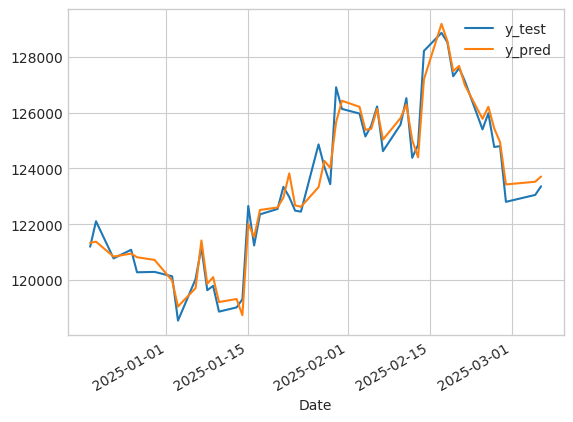

In [433]:
ax = y_test.plot(label="y_test")
ax.plot(y_test.index, y_pred, label="y_pred")
ax.legend()

In [434]:
print("Último valor real:", y_test.iloc[-1])
print("Média do valor real:", y_test.mean())

Último valor real: 123358.0
Média do valor real: 123482.86


In [435]:
# Calcular métricas no treino
y_train_pred = model.predict(X_train_scaled)
r2_train = r2_score(y_train, y_train_pred)
print("R² no treino:", r2_train)

R² no treino: 0.9999691865635314


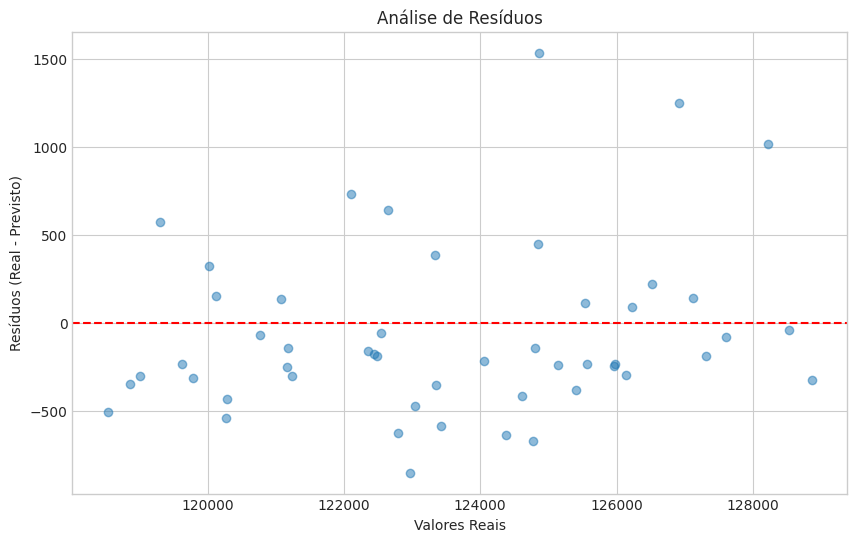

In [436]:
# Gráfico de resíduos (valores reais vs. erros)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Resíduos (Real - Previsto)')
plt.title('Análise de Resíduos')
plt.show()

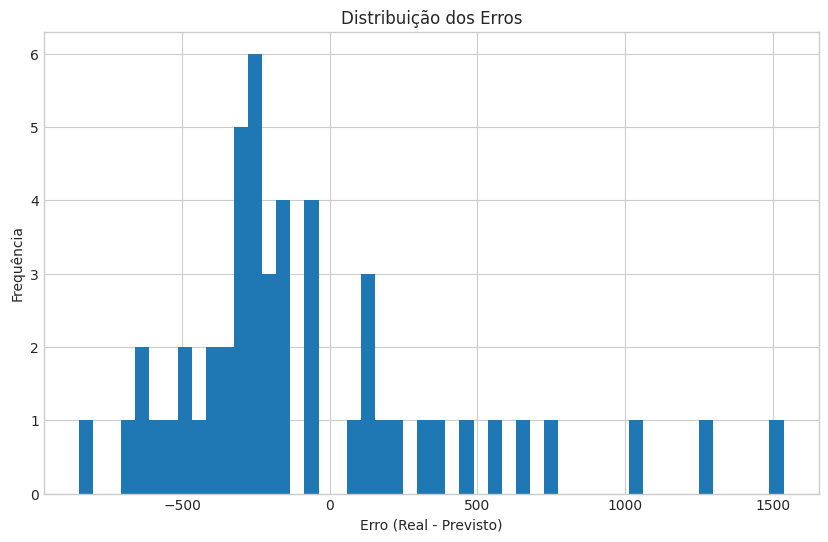

In [437]:
# Histograma dos resíduos
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Erro (Real - Previsto)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros')
plt.show()

In [438]:
# Calcular R² no treino e no teste
r2_train = model.score(X_train_scaled, y_train)
r2_test = model.score(X_test_scaled, y_test)
print(f"R² Treino: {r2_train:.4f}")
print(f"R² Teste: {r2_test:.4f}")

R² Treino: 1.0000
R² Teste: 0.9698


In [439]:
df[('Close', '^BVSP')]


,Close
,^BVSP
Date,
2005-05-17,24413.0
2005-05-18,24898.0
2005-05-19,24829.0
2005-05-20,24522.0
2005-05-23,24215.0
...,...
2025-02-26,124769.0
2025-02-27,124799.0
